# Мини-проект. Практика

**ПОСТАНОВКА ЗАДАЧИ**

Определить качество вина. Решить задачу классификации с использованием SVM и подобрать наилучшее ядро.

**ДАННЫЕ**

Датасет содержит информацию о красных винах и их составе. Целевой переменной является столбец "quality". Это метрика качества вина по шкале от 3 до 8.

**РЕКОМЕНДАЦИИ**

Проанализируйте распределения переменных и корреляцию с таргетом.

Сделайте целевую переменную категориальной ('bad wine': quality < 6.5 и 'good wine': quality > 6.5).

Закодируйте целевую переменную.

Используйте StandardScaler() для преобразования признаков.

Настройте гиперпараметры модели SVC: C, gamma и kernel из ['linear', 'poly', 'rbf', 'sigmoid'].

Используйте метрику accuracy. Также можно смотреть результаты confusion matrix.

Обучите модель с наилучшими параметрами и оцените score на кросс-валидации. 

<a id='0'></a> 
### План проекта
<a href='#1'> **Анализ распределения переменных и корреляции с таргетом**    
<a href='#2'> **Новые признаки и категоризация таргета**   
<a href='#5'> **Наивная модель и модели "из коробки"**      
<a href='#3'> **Подбор ядра**  
<a href='#4'> **Модель и метрики на валидации**     

<a id='1'></a> 
### Анализ распределения переменных и корреляции с таргетом

<a href='#0'> *Вернуться к плану проекта*

In [267]:
import pandas as pd
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
#import pymc3 as pm
import seaborn as sns
import matplotlib.lines as mlines
from scipy import stats
from scipy.stats import loguniform
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [268]:
def show_distination(_list, target):
    '''
    Изображает распределение признаков и боксплоты с выбросами по значениям целевой функции
    '''
    len_list = len(_list)
    length = 16
    if len_list<4:
        length = 4*len_list
    fig, axs = plt.subplots(2,len_list, constrained_layout=True, figsize=(length, 5))
    
    for i in range(len_list):
        
        df[_list[i]].hist(ax=axs[0,i])
        df.boxplot(column=[_list[i]], by=target, ax=axs[1,i])

In [269]:
def iqr_cut(df, df_tmp, y):
    #df_tmp = df[df['num_room']==2]
    iqr = scipy.stats.iqr(df_tmp[y])
    #print(iqr)

    del_index = df_tmp[df_tmp[y]<np.percentile(df_tmp[y],25) - 1.5*iqr].index
    df = df.loc[list(set(df.index)-set(del_index.tolist()))]

    del_index = df_tmp[df_tmp[y]>np.percentile(df_tmp[y],75) + 1.5*iqr].index
    df = df.loc[list(set(df.index)-set(del_index.tolist()))]

In [270]:
# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)

def show_corr(df): 
    '''
    Рисует Матрицу корреляции признаков
    '''
    cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                                 hue = 0.5, as_cmap=True)

    sns.set_context(font_scale=2)

    # Pair grid set up
    g = sns.PairGrid(df)

    # Scatter plot on the upper triangle
    g.map_upper(plt.scatter, s=10, color = 'red')

    # Distribution on the diagonal
    g.map_diag(sns.distplot, kde=False, color = 'red')

    # Density Plot and Correlation coefficients on the lower triangle
    g.map_lower(sns.kdeplot, cmap = cmap)
    g.map_lower(corrfunc);

In [271]:
path = r'F:\SkillFactory\Y2_U21_ЯдерныеФункции\winequality-red'
df = pd.read_csv(os.path.join(path,"winequality-red.csv"), sep=';')

In [272]:
df.tail(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [274]:
# Понижаем размерность данных
cols = list(set(df.columns).difference({'quality'}))
for col in cols:
    df[col] = df[col].astype('float32')
df['quality'] = df['quality'].astype('int16')   

In [275]:
df.tail(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float32
 1   volatile acidity      1599 non-null   float32
 2   citric acid           1599 non-null   float32
 3   residual sugar        1599 non-null   float32
 4   chlorides             1599 non-null   float32
 5   free sulfur dioxide   1599 non-null   float32
 6   total sulfur dioxide  1599 non-null   float32
 7   density               1599 non-null   float32
 8   pH                    1599 non-null   float32
 9   sulphates             1599 non-null   float32
 10  alcohol               1599 non-null   float32
 11  quality               1599 non-null   int16  
dtypes: float32(11), int16(1)
memory usage: 72.0 KB


5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

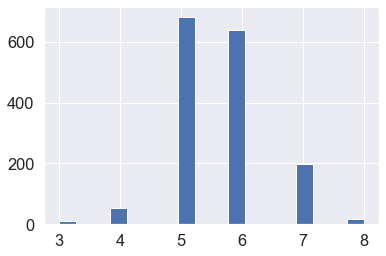

In [277]:
# Распределение оценки качества вина
df['quality'].hist(bins=18);
df['quality'].value_counts()

**Летучая и фиксированная кислотность, лимонная кислота и pH**

Если распределение pH близко к идеальному нормальному распределению, то летучая кислотность и лимонная кислота далеки от этого

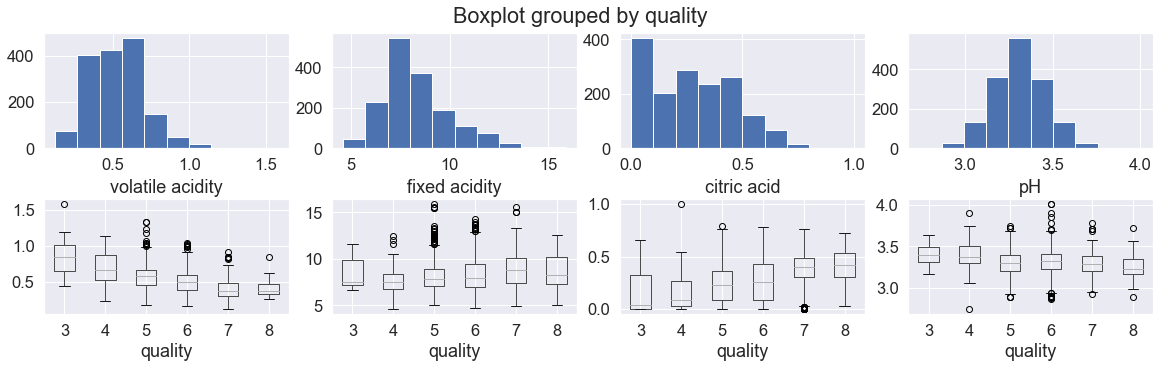

In [278]:
show_distination(['volatile acidity', 'fixed acidity', 'citric acid', 'pH'], 'quality')

Попробуем получить новые признаки:

1. Сумму летучей кислотности с лимонной кислотой
2. От ношение летучей и фиксированной кислотности

In [279]:
df['vc_acidity'] = df['volatile acidity'] + df['citric acid']
df['rel_acidity'] = df['volatile acidity'] / df['fixed acidity']

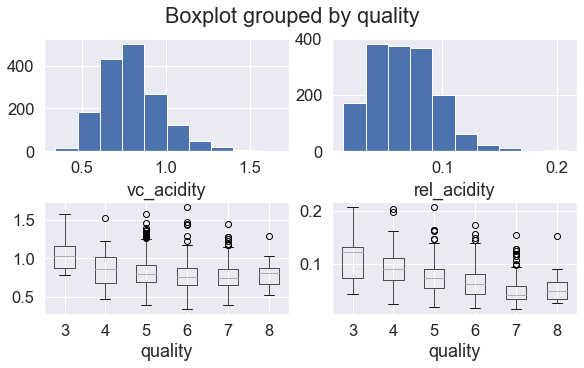

In [280]:
show_distination(['vc_acidity', 'rel_acidity'], 'quality')

**Летучая кислотность, свободный диоксид серы, диоксид серы и сульфаты, как соли производные кислот**

Здесь также понятно, что распределения диоксидов не похожи на нормальные распределения и значения потребуют  преобразований:

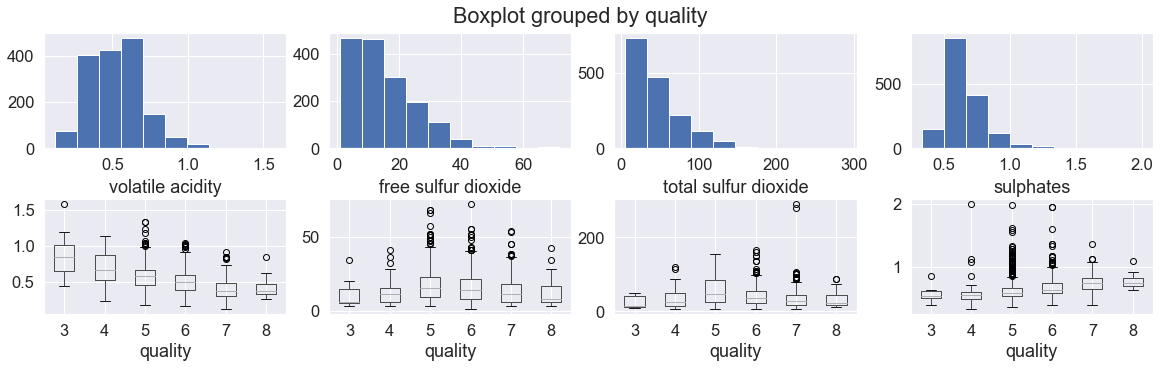

In [281]:
show_distination(['volatile acidity', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates'], 'quality')

In [282]:
df['rel_sulfur_dioxide'] = df['free sulfur dioxide']/df['total sulfur dioxide'] #убрать 'free sulfur dioxide' и 'total sulfur dioxide'
#df['rel_acidity_sulfur'] = df['citric acid']/df['free sulfur dioxide']

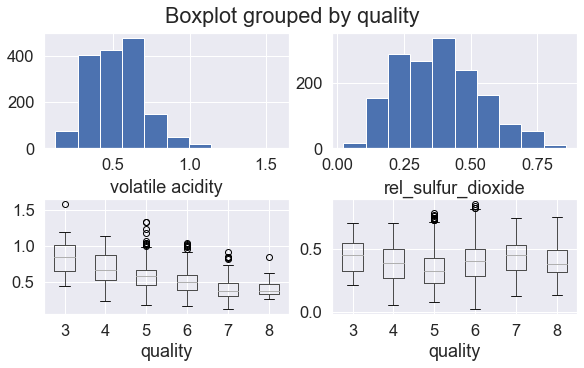

In [283]:
show_distination(['volatile acidity','rel_sulfur_dioxide'], 'quality')

In [284]:
df['sugar_alc'] = df['alcohol']/df['residual sugar']

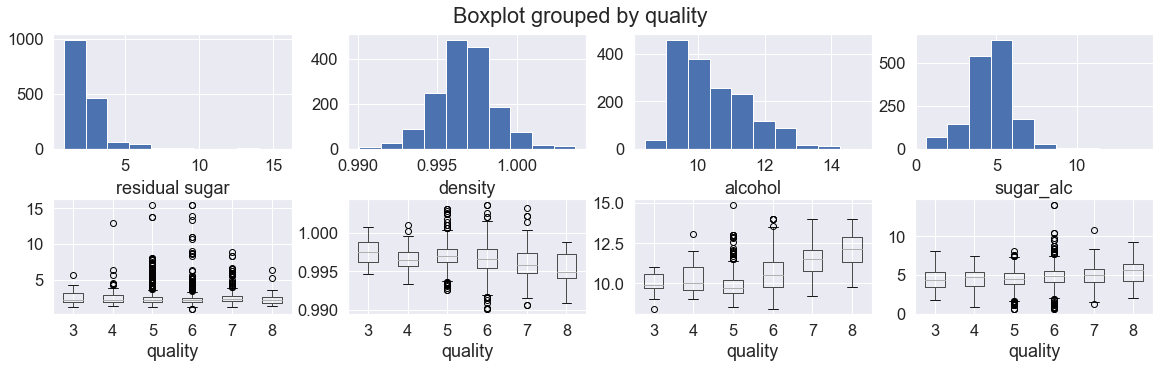

In [285]:
show_distination(['residual sugar','density', 'alcohol','sugar_alc'], 'quality')

In [286]:
df['y'] = np.where(df['quality']>6.5, 1, 0)
df['vc_acidity'] = df['volatile acidity'] + df['citric acid']
df['rel_acidity'] = df['volatile acidity'] / df['fixed acidity']
df['rel_sulfur_dioxide'] = df['free sulfur dioxide']/df['total sulfur dioxide'] #убрать 'free sulfur dioxide' и 'total sulfur dioxide'
df['rel_acidity_sulfur'] = df['citric acid']/df['free sulfur dioxide']
df['sugar_alc'] = df['alcohol']/df['residual sugar']

In [287]:
# Убираем выбросы на основе статистик:

cols = list(set(df.columns).difference({'quality'}))

for qual in df['quality'].unique().tolist():
    
    df_tmp = df[df['quality']==qual]
    
    for col in cols:
        
        iqr_cut(df, df_tmp, col)
    

In [288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float32
 1   volatile acidity      1599 non-null   float32
 2   citric acid           1599 non-null   float32
 3   residual sugar        1599 non-null   float32
 4   chlorides             1599 non-null   float32
 5   free sulfur dioxide   1599 non-null   float32
 6   total sulfur dioxide  1599 non-null   float32
 7   density               1599 non-null   float32
 8   pH                    1599 non-null   float32
 9   sulphates             1599 non-null   float32
 10  alcohol               1599 non-null   float32
 11  quality               1599 non-null   int16  
 12  vc_acidity            1599 non-null   float32
 13  rel_acidity           1599 non-null   float32
 14  rel_sulfur_dioxide    1599 non-null   float32
 15  sugar_alc            

In [289]:
most_correlated = df.corr().abs()['quality'].sort_values(ascending=False)

In [290]:
most_correlated

quality                 1.000000
y                       0.710196
alcohol                 0.476166
volatile acidity        0.390558
rel_acidity             0.343905
sulphates               0.251397
citric acid             0.226373
rel_acidity_sulfur      0.206438
rel_sulfur_dioxide      0.194113
total sulfur dioxide    0.185100
density                 0.174919
vc_acidity              0.145644
sugar_alc               0.134256
chlorides               0.128907
fixed acidity           0.124052
pH                      0.057731
free sulfur dioxide     0.050656
residual sugar          0.013732
Name: quality, dtype: float64

In [291]:
most_correlated = df.corr().abs()['y'].sort_values(ascending=False)
most_correlated

y                       1.000000
quality                 0.710196
alcohol                 0.407315
volatile acidity        0.270712
rel_acidity             0.243449
citric acid             0.214716
sulphates               0.199485
rel_acidity_sulfur      0.185805
density                 0.150459
total sulfur dioxide    0.139517
rel_sulfur_dioxide      0.131454
fixed acidity           0.120061
chlorides               0.097308
free sulfur dioxide     0.071747
sugar_alc               0.071493
pH                      0.057283
residual sugar          0.047779
vc_acidity              0.037470
Name: y, dtype: float64

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


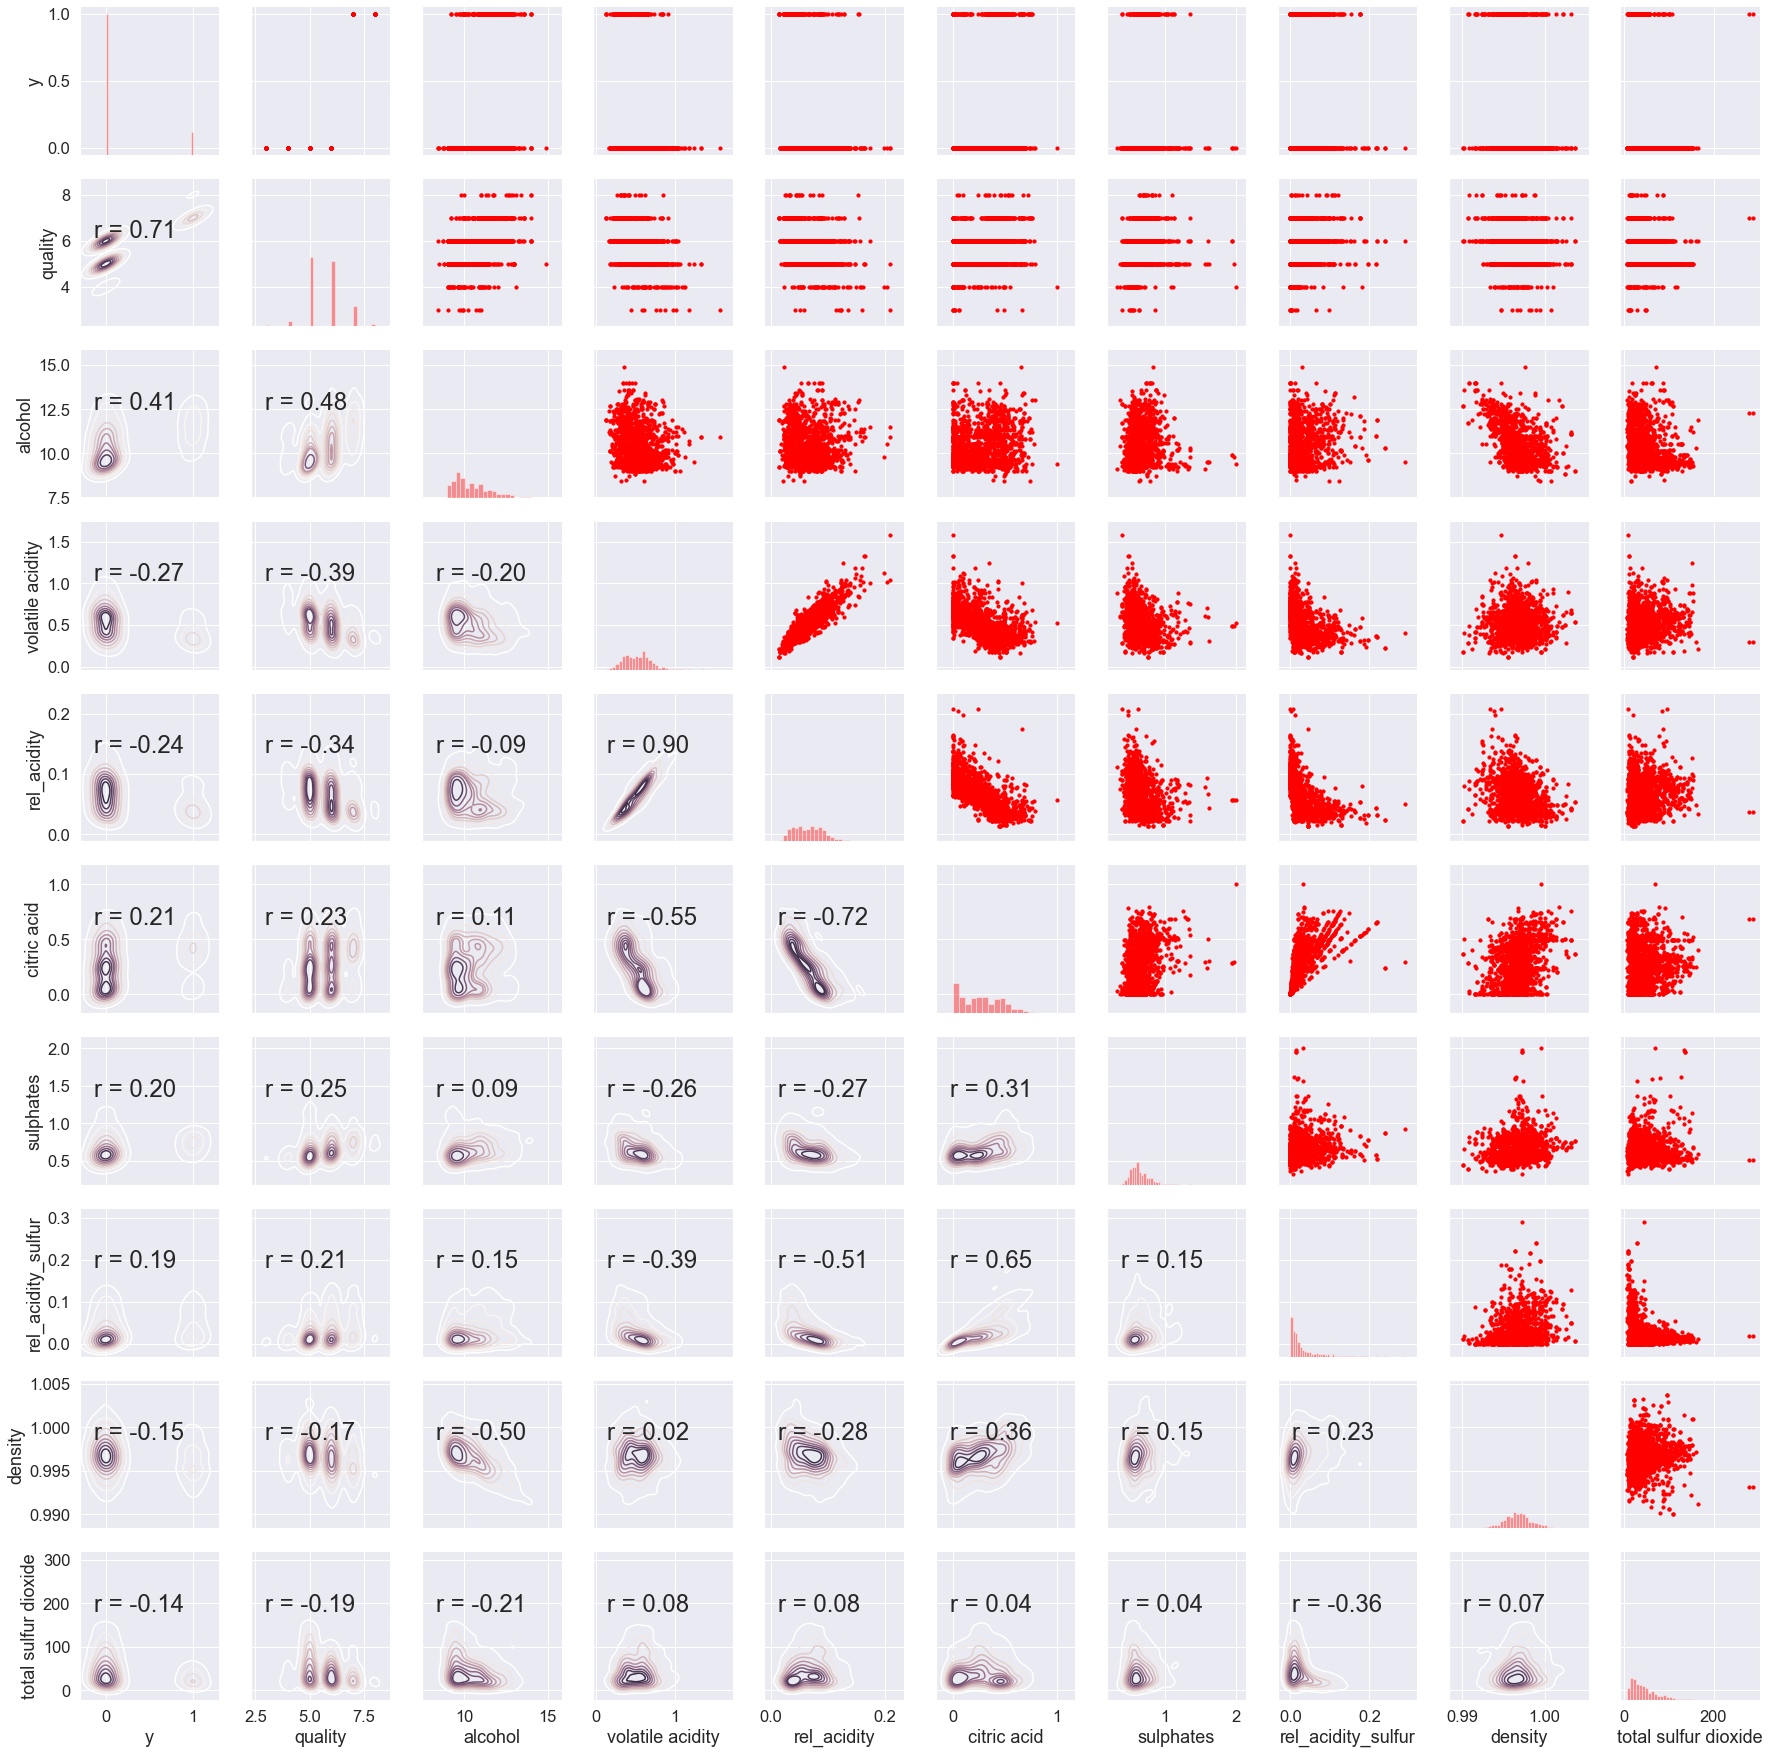

In [292]:
show_corr(df[most_correlated.index[:10].tolist()])

In [293]:
most_correlated.index[2:10].tolist()

['alcohol',
 'volatile acidity',
 'rel_acidity',
 'citric acid',
 'sulphates',
 'rel_acidity_sulfur',
 'density',
 'total sulfur dioxide']

In [294]:
df[most_correlated.index[2:10].tolist()]

,alcohol,volatile acidity,rel_acidity,citric acid,sulphates,rel_acidity_sulfur,density,total sulfur dioxide
0,9.4,0.700,0.094595,0.00,0.56,0.000000,0.99780,34.0
1,9.8,0.880,0.112821,0.00,0.68,0.000000,0.99680,67.0
2,9.8,0.760,0.097436,0.04,0.65,0.002667,0.99700,54.0
3,9.8,0.280,0.025000,0.56,0.58,0.032941,0.99800,60.0
4,9.4,0.700,0.094595,0.00,0.56,0.000000,0.99780,34.0
...,...,...,...,...,...,...,...,...
1594,10.5,0.600,0.096774,0.08,0.58,0.002500,0.99490,44.0
1595,11.2,0.550,0.093220,0.10,0.76,0.002564,0.99512,51.0
1596,11.0,0.510,0.080952,0.13,0.75,0.004483,0.99574,40.0
1597,10.2,0.645,0.109322,0.12,0.71,0.003750,0.99547,44.0


<a id='2'></a> 
### Новые признаки и категоризация таргета

<a href='#0'> *Вернуться к плану проекта*

In [295]:
df['y'] = np.where(df['quality']>6.5, 1, 0)
df['vc_acidity'] = df['volatile acidity'] + df['citric acid']
df['rel_acidity'] = df['volatile acidity'] / df['fixed acidity']
df['rel_sulfur_dioxide'] = df['free sulfur dioxide']/df['total sulfur dioxide'] #убрать 'free sulfur dioxide' и 'total sulfur dioxide'
df['rel_acidity_sulfur'] = df['citric acid']/df['free sulfur dioxide']
df['sugar_alc'] = df['alcohol']/df['residual sugar']

<a id='5'></a> 
### Наивная модель и модели "из коробки"

<a href='#0'> *Вернуться к плану проекта*

In [296]:
# масштабирование данных
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_scaled = scale.fit_transform(df[most_correlated.index[2:10].tolist()])

y = df['y']

In [297]:
X_scaled.shape

(1599, 8)

In [298]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [299]:
# Будем использовать наивный байес в качестве baseline 
gnb = GaussianNB()
cv = cross_val_score(gnb,X_scaled,y,cv=5)
print(cv)
print(cv.mean())

[0.878125   0.715625   0.88125    0.725      0.84952978]
0.8099059561128528


In [300]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_scaled,y,cv=5)
print(cv)
print(cv.mean())

[0.85625    0.85625    0.890625   0.83125    0.88401254]
0.8636775078369906


In [301]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_scaled,y,cv=5)
print(cv)
print(cv.mean())

[0.890625   0.83125    0.878125   0.825      0.86520376]
0.8580407523510971


In [302]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_scaled,y,cv=5)
print(cv)
print(cv.mean())

[0.871875   0.875      0.890625   0.865625   0.86520376]
0.8736657523510972


In [303]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_scaled,y,cv=5)
print(cv)
print(cv.mean())

[0.890625   0.859375   0.871875   0.84375    0.86520376]
0.8661657523510972


<a id='3'></a> 
### Подбор ядра

<a href='#0'> *Вернуться к плану проекта*

**GRID SEARCH**

In [102]:
from sklearn.model_selection import GridSearchCV
param_grid = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [10**(-3),10**(-1),1.0,10.],
              'gamma':  loguniform.rvs(10**(-3),1, size=5)}
model = SVC()
clf = GridSearchCV(model, param_grid=param_grid, cv=3, scoring='accuracy')

In [103]:
model_grid = clf.fit(X_scaled, y)

In [104]:
print(model_grid.best_score_)
print(model_grid.best_params_)

0.8736710444027517
{'C': 1.0, 'gamma': 0.1540172324514156, 'kernel': 'rbf'}


**RANDOM SEARCH**

In [105]:
from sklearn.model_selection import RandomizedSearchCV 
clf = RandomizedSearchCV(model,param_grid,n_iter=100, cv=3, random_state=42)

In [106]:
model_rs = clf.fit(X_scaled, y)

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [107]:
print(model_rs.best_score_)
print(model_rs.best_params_)

0.8736710444027517
{'kernel': 'rbf', 'gamma': 0.1540172324514156, 'C': 1.0}


**TPOT**

In [127]:
from tpot import TPOTClassifier, TPOTRegressor
from deap.gp import Primitive

In [138]:
param_grid = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [1e-3, 1e-2, 1e-1, 0.5, 1.],
              'gamma':  [1e-3, 1e-2, 1e-1, 0.5, 1.]}

In [145]:
tpot_classifier = TPOTClassifier(generations = 5, 
                                 population_size = 50, 
                                 offspring_size = 25,
                                 verbosity = 2,
                                 early_stop=8,
                                 config_dict = {'sklearn.svm.SVC': param_grid},
                                 cv = 3
                                )

In [146]:
tpot_classifier.fit(X_scaled, y)
tpot_classifier.export(r'f:\tmp\tpot_digits_pipeline.py')

                                                                             
Generation 1 - Current best internal CV score: 0.8705440900562852
                                                                              
Generation 2 - Current best internal CV score: 0.8717948717948717
                                                                              
Generation 3 - Current best internal CV score: 0.8717948717948717
                                                                              
Generation 4 - Current best internal CV score: 0.8717948717948718
                                                                              
Generation 5 - Current best internal CV score: 0.8730456535334584
                                                                              
Best pipeline: SVC(SVC(CombineDFs(input_matrix, input_matrix), C=0.5, gamma=0.001, kernel=sigmoid), C=0.5, gamma=0.1, kernel=rbf)


In [148]:
tpot_classifier.config_dict

{'sklearn.svm.SVC': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
  'C': [0.001, 0.01, 0.1, 0.5, 1.0],
  'gamma': [0.001, 0.01, 0.1, 0.5, 1.0]}}

In [147]:
tpot_classifier.score(X_scaled, y)

0.892432770481551

**БАЙЕСОВСКАЯ ОПТИМИЗАЦИЯ**

In [114]:
'''
from sklearn.model_selection import GridSearchCV
gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':Cs, 'gamma': gammas }
svc = SVC()

gs = GridSearchCV(estimator=svc, param_grid=param_grid)
gs.fit(X_scaled, y)
'''

"\nfrom sklearn.model_selection import GridSearchCV\ngammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]\nCs = [1, 10, 100, 1e3, 1e4, 1e5]\nparam_grid = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':Cs, 'gamma': gammas }\nsvc = SVC()\n\ngs = GridSearchCV(estimator=svc, param_grid=param_grid)\ngs.fit(X_scaled, y)\n"

In [115]:
param_grid = {'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'svc__C': hp.loguniform(label='C', 
                        low=-4*np.log(10), 
                        high=2*np.log(10)),
              'svc__gamma':  hp.loguniform(label='gamma', 
                        low=-4*np.log(10), 
                        high=2*np.log(10))}

In [116]:
model =  Pipeline([('svc', SVC())])

In [117]:
def objective(params, model,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    model.set_params(**params)
    
    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=model, X=X_train, y=y_train, 
                            scoring='roc_auc', cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

In [118]:
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, model=model, X_train=X_scaled, y_train=y),
          # пространство поиска гиперпараметров  
            space=param_grid,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций (можно ещё указать  время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials
          # random state
            #rstate=np.random.RandomState(42),
          # progressbar
            #show_progressbar=False
        )

 12%|█▎        | 5/40 [00:00<00:00, 45.45trial/s, best loss=?]

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 2.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, 

 60%|██████    | 24/40 [00:00<00:00, 78.74trial/s, best loss=?]

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 2.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, 

100%|██████████| 40/40 [00:00<00:00, 79.68trial/s, best loss=?]


C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 2.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, 

AllTrialsFailed: 

<a id='4'></a> 
### Модель и метрики на валидации

<a href='#0'> *Вернуться к плану проекта*

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,random_state=42)

In [248]:
svc = SVC(probability = True, C=1, gamma=0.1, kernel='rbf')
cv = cross_val_score(svc,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.88333333 0.875      0.875      0.88333333 0.89958159]
0.8832496513249651


In [249]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.88333333 0.87916667 0.86666667 0.87916667 0.89958159]
0.8815829846582984


In [250]:
svc = SVC(probability = True, kernel='rbf', C =1., gamma=0.1)
cv = cross_val_score(svc,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.88333333 0.875      0.875      0.88333333 0.89958159]
0.8832496513249651


In [251]:
svc.fit(X_train, y_train)

SVC(gamma=0.1, probability=True)

In [252]:
predictions = svc.predict(X_test)

In [253]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions, labels=svc.classes_)

In [254]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svc.classes_)

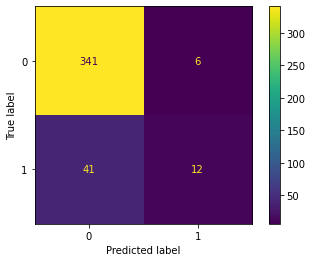

In [255]:
disp.plot()

In [256]:
y_test.sum(), predictions.sum()

(53, 18)

TRAIN: 1199 TEST: 400
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       346
           1       0.88      0.26      0.40        54

    accuracy                           0.90       400
   macro avg       0.89      0.63      0.67       400
weighted avg       0.89      0.90      0.87       400

TRAIN: 1199 TEST: 400
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       346
           1       0.50      0.20      0.29        54

    accuracy                           0.86       400
   macro avg       0.69      0.59      0.61       400
weighted avg       0.83      0.86      0.84       400

TRAIN: 1199 TEST: 400
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       346
           1       0.83      0.19      0.30        54

    accuracy                           0.89       400
   macro avg       0.86      0.59      0.62       400
weighted

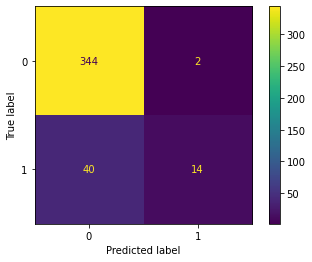

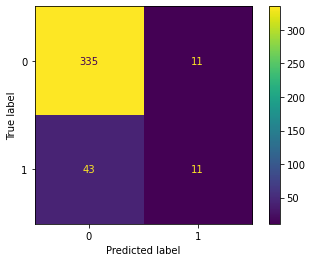

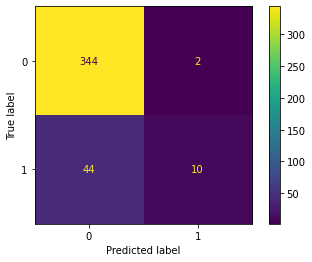

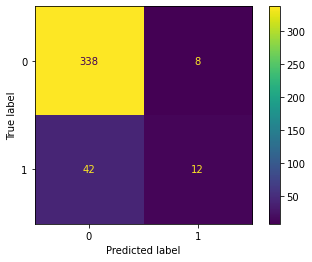

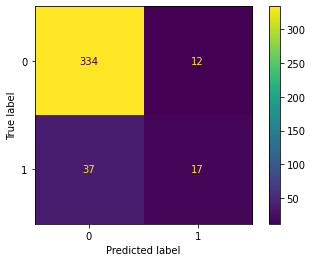

In [261]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
_score = []
for train_index, test_index in sss.split(X_scaled, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    svc = SVC(probability = True, C=1, gamma=0.1, kernel='rbf')
    svc.fit(X_train, y_train)
    _score.append(svc.score(X_test, y_test))
    
    predictions = svc.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=svc.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svc.classes_)
    
    print (classification_report(y_test,predictions))
    
    disp.plot()
    
    
    
    #print(sum(y_train), sum(y_test))

In [240]:
_score, np.mean(_score)

([0.896875, 0.8625, 0.8875, 0.878125, 0.859375], 0.8768749999999998)

**Выводы**

Поскольку классы у нас неравны, то метрика "accuracy" является бесполезной. Метрики для каждого класса
Precision, recall и F-мера являются более интепретируемыми. 
Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.
В нашем случае больший класс, отмеченнй как 0, является винами, имеющими рейтинг  < 6.5
Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов.